In [ ]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [2]:
data = pd.read_excel("MarketDATA.xlsx")

In [ ]:
data.head()

In [4]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data1 = data.sort_index()

In [5]:
# Encode the Crop column
label_encoder = LabelEncoder()
data['Crop_encoded'] = label_encoder.fit_transform(data['Crop'])

In [ ]:
data.head(5)

In [7]:
scaler = MinMaxScaler()
data[['Market_Price', 'Production_Cost','Crop_encoded']] = scaler.fit_transform(
    data[['Market_Price', 'Production_Cost','Crop_encoded']]
)

In [ ]:
data.head(100)

In [9]:
data1 = data.drop(columns=['Crop'])

In [ ]:
data1.head()

In [11]:
def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        target = data[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets)


In [39]:
# Define noise function
def add_noise(data, noise_factor=0.01):
    noise = noise_factor * np.random.randn(*data.shape)
    noisy_data = data + noise
    return noisy_data

scaler = MinMaxScaler()

crops = data1['Crop_encoded'].unique()  # Get unique crops

all_sequences = []
all_targets = []

for crop in crops:
    # Filter data by crop and drop 'Crop_encoded'
    # crop_data = data1[data1['Crop_encoded'] == crop].drop('Crop_encoded', axis=1)
    crop_data = data1[data1['Crop_encoded'] == crop]
    # Ensure that the crop data has at least 12 rows for sequence creation
    if len(crop_data) >= 12:
        # Scale the crop data
        scaled_crop_data = scaler.fit_transform(crop_data)
        
        # Add noise to the scaled data
        noisy_data = add_noise(scaled_crop_data, noise_factor=0.01)  # Adjust noise_factor as needed
        
        # Create sequences and targets (12-month sequences)
        sequences, targets = create_sequences(noisy_data, sequence_length=12)
        
        # Append the sequences and targets
        all_sequences.append(sequences)
        all_targets.append(targets)

# Combine the list of sequences and targets into numpy arrays
X = np.concatenate(all_sequences)
y = np.concatenate(all_targets)

print(f"Shape of X: {X.shape}, Shape of y: {y.shape}")


Shape of X: (3996, 12, 4), Shape of y: (3996, 4)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [41]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))


In [101]:
from tensorflow.keras.layers import  BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the model
model = Sequential()

# First LSTM layer
model.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(BatchNormalization())  # Batch Normalization to stabilize training

# Second LSTM layer
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# Third LSTM layer
model.add(LSTM(32, activation='tanh'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(y_train.shape[1]))  # Adjust to match your target output shape

# Compile the model with a lower learning rate for the Adam optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

# Learning rate scheduler to reduce the learning rate if validation loss stops improving
lr_scheduler = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5, min_lr=1e-6, verbose=1)



/home/ghost/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [102]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 12, 128)        │        68,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 12, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 12, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 12, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,820 (511.02 KB)

 Trainable params: 130,436 (509.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [103]:
# Train the model
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, callbacks=[lr_scheduler])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 51ms/step - loss: 0.1376 - mse: 0.1376 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - loss: 0.0521 - mse: 0.0521 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.0487 - mse: 0.0487 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0456 - mse: 0.0456 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 0.0451 - mse: 0.0451 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0442 - mse: 0.0442 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0428 - mse: 0.0428 - learning_rate: 0.0010
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.0424 - mse: 0.0424 - learning_rate: 0.0010
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0418 - mse: 0.0418 - learning_rate: 0.0010
Epoch 10/100
100/100 ━━━━━━━━━━━━━━

In [104]:
model.save("marketlstm.keras")

In [105]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import math


In [106]:
# Generate predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)

# Compute RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Compute R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Mean Squared Error (MSE): 0.03652009566597575
Root Mean Squared Error (RMSE): 0.1911023172700314
R-squared (R²): 0.11011207371630485


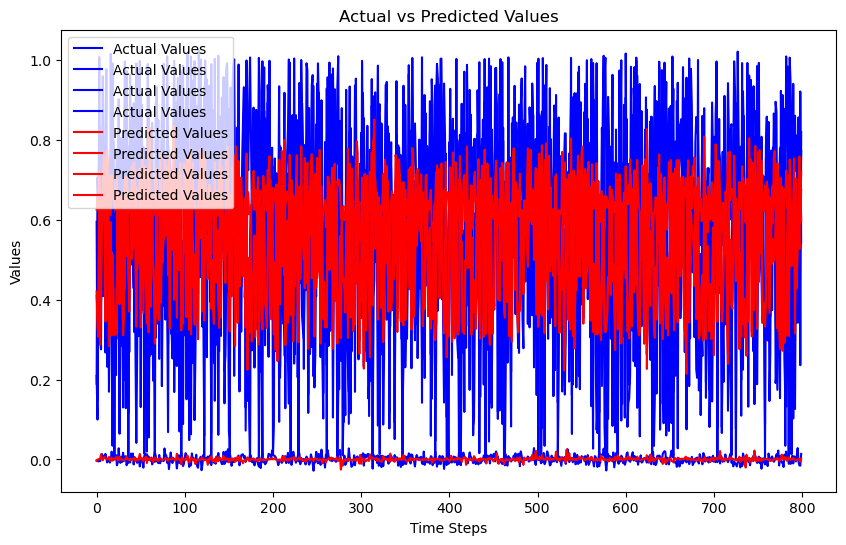

In [107]:
plt.figure(figsize=(10, 6))

# Plot predicted vs actual values
plt.plot(y_test, label='Actual Values', color='b')
plt.plot(y_pred, label='Predicted Values', color='r')

# Labels and Title
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


In [22]:
# # Compute residuals
# residuals = y_test - y_pred

# # Plot residuals
# plt.figure(figsize=(10, 6))
# plt.scatter(range(len(residuals)), residuals, color='purple')
# plt.axhline(y=0, color='black', linestyle='--')

# # Labels and Title
# plt.title('Residuals (Errors)')
# plt.xlabel('Time Steps')
# plt.ylabel('Residuals')

# # Show the plot
# plt.show()


In [24]:
# from keras.models import Sequential
# from keras.layers import LSTM, Dense, Dropout
# from keras.optimizers import Adam

# model = Sequential()
# model.add(LSTM(100, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))  # Adding dropout to reduce overfitting
# model.add(LSTM(50, activation='tanh'))
# model.add(Dropout(0.2))
# model.add(Dense(y_train.shape[1]))  # Output layer for regression

# optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
# model.compile(optimizer=optimizer, loss='mse')

# # Fit the model with a validation set
# # Train the model
# model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[lr_scheduler])


In [ ]:
# Generate predictions
y_pred = model.predict(X_test)

# Compute MSE
mse = mean_squared_error(y_test, y_pred)

# Compute RMSE (Root Mean Squared Error)
rmse = math.sqrt(mse)

# Compute R-squared
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R²): {r2}')


In [108]:
from tensorflow.keras.models import load_model
import os
print(os.getcwd())

loaded_model = load_model('lstm_model.keras')

ValueError: File not found: filepath=lstm_model.keras. Please ensure the file is an accessible `.keras` zip file.

In [84]:
data2 = pd.read_excel("MarketDATA.xlsx")
data2 =data2[data2['Date'] < '2024-11-01']

In [85]:

data2['Date'] = pd.to_datetime(data2['Date'])
data2.set_index('Date', inplace=True)
# Encode the Crop column
label_encoder = LabelEncoder()
data2['Crop_encoded'] = label_encoder.fit_transform(data2['Crop'])
data2.head()
# Filter the dataset for Crop_encoded 23
crop_23_data = data2[data2['Crop_encoded'] == 23].drop(columns=['Crop'])

# Check if there is enough data
if len(crop_23_data) < 12:
    raise ValueError("Not enough data to create a sequence.")

# Get the last 12 months of data for this crop
last_12_months = crop_23_data.tail(12)

# Scale the last 12 months of data
scaled_last_12_months = scaler.fit_transform(last_12_months)

# print(scaled_last_12_months)
# Reshape for LSTM input (samples, time steps, features)
input_data = scaled_last_12_months.reshape((1, scaled_last_12_months.shape[0], scaled_last_12_months.shape[1]))

# Make prediction
predicted_scaled = model.predict(input_data)

# Inverse transform the predicted values
predicted_values = scaler.inverse_transform(predicted_scaled)

# predicted_values
# Assuming you want the prediction for the first target variable (e.g., Market Price)
predicted_value_for_first_target = predicted_values  # Adjust index as needed
print(f'Predicted value for next month (Crop 23): {predicted_value_for_first_target}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted value for next month (Crop 23): [[15.374278   5.1524887 71.36831   22.999283 ]]


In [86]:
data4  = data2[data2['Crop_encoded'] == 23]

In [87]:
data4.tail()

,Crop,Market_Price,Production_Cost,Gross_Profit_Margin,Crop_encoded
Date,,,,,
2024-06-01,Cabbage,15.65,10.67,31.85,23
2024-07-01,Cabbage,18.60,6.58,64.63,23
2024-08-01,Cabbage,8.04,5.57,30.78,23
2024-09-01,Cabbage,17.35,4.17,75.98,23
2024-10-01,Cabbage,16.95,3.72,78.06,23


In [89]:
# # Create a new DataFrame for the new row
data5 =data2[data2['Date'] < '2024-11-01']
# new_row = pd.DataFrame({
#     'Date': [pd.to_datetime('2024-11-01')],
#     'Crop': ['Cabbage'],
#     'Market_Price': [predicted_values[0][0]],
#     'Production_Cost': [predicted_values[0][1]],
#     'Gross_Profit_Margin': [predicted_values[0][2]],
#     'Crop_encoded': 23,
# })

In [90]:
# new_row

,Date,Crop,Market_Price,Production_Cost,Gross_Profit_Margin,Crop_encoded
0,2024-11-01,Cabbage,15.374278,5.152489,71.368309,22.999283


In [109]:
from tensorflow.keras.models import load_model

loaded_model = load_model('marketlstm.keras')